In [1]:
import os
import sys 
os.chdir(os.path.join(os.getenv('HOME'), 'RPOSE'))
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/core'))
sys.path.append(os.path.join(os.getcwd() + '/segmentation'))

import pickle
import numpy as np 

# p = "/home/jonfrey/RPOSE/notebooks/Mode.MUTIPLE_INIT_POSES_data_final.pkl" # experiment with predicted flow and valid
p = "/home/jonfrey/RPOSE/notebooks/Mode.MUTIPLE_INIT_POSES_gt_valid_data_final.pkl"

# more noise
p = "/home/jonfrey/RPOSE/notebooks/Mode.MUTIPLE_INIT_POSES_gt_valid_more_noise_trained_data_final.pkl"

p = "/media/scratch1/jonfrey/results/rpose/training_flow_dry_run/2021-07-02T10:40:27_no_synthetic_data/Mode.MUTIPLE_INIT_POSES_eval_data_final.pkl"
p = "/media/scratch1/jonfrey/results/rpose/training_flow_reloaded/2021-07-03T16:20:38_iterations_2/Mode.MUTIPLE_INIT_POSES_eval_data_final.pkl"

p =  "/media/scratch1/jonfrey/results/rpose/pose_prediction/gt_valid/Mode.MUTIPLE_INIT_POSES_eval_data_final.pkl"

p = "docs/result_final.pkl"

p = "docs/result_inter_1000.pkl"

p = "docs/both_epnp_6iter.pkl"
p = "docs/tracking.pkl"

p = "docs/315.pkl"
p = "docs/336.pkl"

p = "docs/306.pkl"
p = "docs/223.pkl"
with open(p, 'rb') as f:
     data = pickle.load(f)

data_2 = {}
data_new = {}
print( data.keys() )
for k in data.keys():
    try:
        data_new[k] =  data[k][:,0]
        for l in range(data[k].shape[1]):
            data_2 [k+f"_{l}"] = data[k][:,l]
            # data[k+"_l"] = data[k][:,l]
    except:
        data_new[k] =  data[k]
        pass
    
import pandas as pd
d = { k: data_new[k] for k in ['add_s', 'adds', 'idx_arr', 'ratios_arr', 'valid_corrospondences', 'init_adds_arr', 'init_add_s_arr', 'epe','repro_errors'] }
df = pd.DataFrame.from_dict( d ) 


dict_keys(['add_s', 'adds', 'idx_arr', 'ratios_arr', 'valid_corrospondences', 'init_adds_arr', 'init_add_s_arr', 'epe', 'h_init_all', 'h_pred_all', 'violation_arr', 'repro_errors'])


In [15]:

dis = data['add_s'][:,0] - data['init_add_s_arr'][:,0] 
m = dis != np.inf
idx = np.argmax((dis[m]))

data['add_s'][:,0][idx ] 
data['init_add_s_arr'][:,0][idx ] 

0.043606773018836975

In [380]:
data['add_s'][data['add_s'] == np.inf] = data['init_add_s_arr'][data['add_s'] == np.inf]
data['adds'][data['adds'] == np.inf] = data['init_adds_arr'][data['adds'] == np.inf]

compute_auc(data['adds'][:,0])

84.26240628659096

In [320]:
from pose_estimation import compute_auc

vio = np.array( [ d.value for d in data["violation_arr"].flatten()]).reshape( data["violation_arr"].shape)

val = np.linalg.norm( (data['h_init_all'] - data['h_pred_all'])[:,:,:3,3], axis=2)
val = data['r_repro_arr']



    
# Results Abblation Consecutive Refinement
for tar in range( 0, 3):
    # latest with fallback
    num = np.zeros( data['epe'].shape )
    for i in range( m.shape[0]):
        val = np.where(vio[i] == 4)[0]
        for k in range(0, tar+1):
            k = tar-k
            if k in val:
                val = k
                break
            if k == 0:
                val = 0
        num[i,val] = 1 
    
    print(f"{tar}th Iteration: ", compute_auc_mix(data['add_s'][num == 1], data['adds'][num == 1] , data['idx_arr'] ),
     compute_auc ( data['adds'][num == 1] ) )

    
val = data['repro_errors']
m= np.argmin( val ,axis=1)
num = np.zeros( data['epe'].shape )
for i in range( m.shape[0]):
    num[i,m[i]] = 1
    
print(f"Repro Error: ", compute_auc_mix(data['add_s'][num == 1], data['adds'][num == 1] , data['idx_arr'] ),
     compute_auc ( data['adds'][num == 1] ) )


val = data['add_s']
m= np.argmin( val ,axis=1)
num = np.zeros( data['epe'].shape )
for i in range( m.shape[0]):
    num[i,m[i]] = 1
print(f"Optimal: ", compute_auc_mix(data['add_s'][num == 1], data['adds'][num == 1] , data['idx_arr'] ),
     compute_auc ( data['adds'][num == 1] ) )


IndexError: boolean index did not match indexed array along dimension 0; dimension is 11694 but corresponding boolean dimension is 14025

In [364]:
(data['h_init_all'][:,0,:3,3] - data['h_pred_all'][:,0,:3,3] ).mean(axis=1)

array([ 0.00265591,  0.01004235, -0.02417741, ..., -0.00011791,
        0.00559588,  0.00650622])

In [369]:
# Experiment when to fall back on inital pose:

dif = np.linalg.norm( data['h_init_all'][:,0,:3,3] - data['h_pred_all'][:,0,:3,3] , axis = 1 )

m1 = data['repro_errors'][:,0] < 100
tmp = np.zeros( data['adds'][:,0].shape )
tmp[m1] = data['adds'][m1,0]

use_pose_cnn =True
if use_pose_cnn:
    p= data_posecnn['adds'][:,None]
else:
    p = data['init_adds_arr']
    
tmp[m1 == False] = p[m1 == False,0]

print( compute_auc ( data['adds'][:,0] ), compute_auc ( tmp ), sum(m1), m1.shape )


def compute_auc_mix(add, adds, obj):
    sym = []
    for ind in obj.tolist():
      sym.append(
        not (int(ind) + 1 in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18])
      )
    sym = np.array(sym)

    non_sym = sym == False
    mix = add[sym].tolist() + adds[non_sym].tolist()
    return compute_auc(np.array(mix))
    
idx = 0
print(compute_auc_mix(data['add_s'][:,idx], data['adds'][:,idx] , data['idx_arr'] ),
 compute_auc(data['adds'][:,idx] ), 
 (vio[:,idx]!=4).sum() )

84.26240628659096 84.25361420653608 13366 (14025,)
77.5199325752267 84.26240628659096 1019


In [49]:
from pose_estimation import compute_auc

vio = np.array( [ d.value for d in data["violation_arr"].flatten()]).reshape( data["violation_arr"].shape)

val = np.linalg.norm( (data['h_init_all'] - data['h_pred_all'])[:,:,:3,3], axis=2)
val = data['repro_errors']
val = data['add_s']
val = data['epe']
val = data['repro_errors']
m= np.argmin( val ,axis=1)
num = np.zeros( data['adds'].shape )
for i in range( m.shape[0]):
    num[i,m[i]] = 1
    

print( 'ADDS best repro', compute_auc ( data['adds'][num == 1] ), 'Default-Iter1:', compute_auc ( data['adds'][:,0] ) )

ADDS best repro 84.86548610654064 Default-Iter1: 84.06338232542836


In [370]:

#for i in range(data.shape[0]):
#    for j in range(data.shape[0]):
vio = np.array( [ d.value for d in data["violation_arr"].flatten()]).reshape( data["violation_arr"].shape)
(vio != 4).sum()

num = np.zeros( data['adds'].shape )
for i in range( vio.shape[0]):
    if vio[i][0] == 4:
        num[i,0] = 1
    if vio[i][1] == 4:
        num[i,0] = 0
        num[i,1] = 1
    if vio[i][2] == 4:
        num[i,0] = 0
        num[i,1] = 0
        num[i,2] = 1
        
np.unique( data['idx_arr'][ vio[:,0] != 4 ], return_counts=True )

vio[:,0][ vio[:,0] != 4]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [374]:
np.unique( vio,return_counts=True )

(array([1, 3, 4]), array([  551,   468, 13006]))

In [4]:
mask_pred = data['adds'] < data['init_adds_arr']

res = np.concatenate( [data['adds'][mask_pred], data['init_adds_arr'][mask_pred==False] ], axis = 0)

compute_auc( res )

86.47219831353985

In [21]:
vio = np.array( [ d.value for d in data['violation_arr'][:,0]])
mask_pred

array([ True,  True,  True, ...,  True,  True,  True])

In [46]:
vio = np.array( [ d.value for d in data['violation_arr'][:,0]])
best = 0
mask_pred = (data['ratios_arr'][:,0] > 0.1) * ( vio == 4 ) # * (data['valid_corrospondences'] < i)

# data['init_add_s_arr'][:,0][mask_pred==False]


selection = np.concatenate( [data['add_s'][:,0][mask_pred], data['init_add_s_arr'][:,1][mask_pred==False] ], axis = 0)
df['add_s'] = selection

selection = np.concatenate( [data['adds'][:,0][mask_pred], data['init_adds_arr'][:,0][mask_pred==False] ], axis = 0)
df['adds'] = selection

res = compute_auc( selection )
print( "RES WITH FILTERING", res, "rejection: ", (mask_pred==False).sum())
#if res > best:
#    best = res
#    print(i, res)
        
best_value_ransacinlier = 0.06
print( "Normal", compute_auc( data['adds'][:,0] ) )

RES WITH FILTERING 84.2308278629646 rejection:  577
Normal 83.93656999371788


In [335]:
with open('/home/jonfrey/PoseCNN-PyTorch/data_posecnn.pickle', 'rb') as handle:
    posecnn = pickle.load(handle)
data_posecnn = {}
data_posecnn['add_s'] = np.array( [d['distances_non'] for d in posecnn])
data_posecnn['adds'] = np.array( [d['distances_sys'] for d in posecnn])
data_posecnn['idx_arr'] = np.array( [d['cls_index']-1 for d in posecnn])
df_posecnn = pd.DataFrame.from_dict( data_posecnn ) 
df_posecnn 

,add_s,adds,idx_arr
0,0.010331,0.006101,0
1,0.015830,0.005267,5
2,0.082734,0.047821,13
3,0.127282,0.081377,18
4,0.058098,0.032544,19
...,...,...,...
14020,0.014305,0.007267,3
14021,0.021800,0.012786,5
14022,0.010457,0.004589,8
14023,0.050037,0.017271,14


Experiment: ADDS to EPE


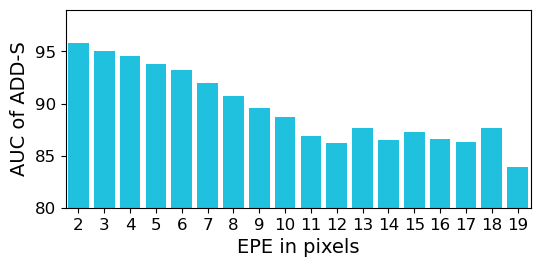

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

print ( "Experiment: ADDS to EPE")

epe = df["epe"].to_numpy()
adds = df["adds"].to_numpy()

m_fin = np.isfinite(epe)
epe = epe[m_fin]
adds = adds[m_fin]

sta = 2
sto = 20
b = np.digitize(epe, np.arange(sta,sto,1) , right=False)
y = []
for i in range(b.max()):
    ma = b == i
    #print( compute_auc( adds[ma] ), epe[ma].mean(), ma.sum() )
    y.append( compute_auc( adds[ma] ) )

import seaborn as sns
from matplotlib import pyplot
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fig, ax = pyplot.subplots(figsize=(6,3))
ax = sns.barplot(ax=ax, x=np.arange(sta,sto,1), y=y, color=sns.color_palette("bright")[-1])
ax.set_ylim([80, 99])
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.set(xlabel='EPE in pixels', ylabel='AUC of ADD-S')
plt.gcf().subplots_adjust(bottom=+0.22)

fig.savefig("/home/jonfrey/RPOSE/docs/adds_mean_vs_epe.png", dpi = 600)

Experiment: ADD-S to EPE


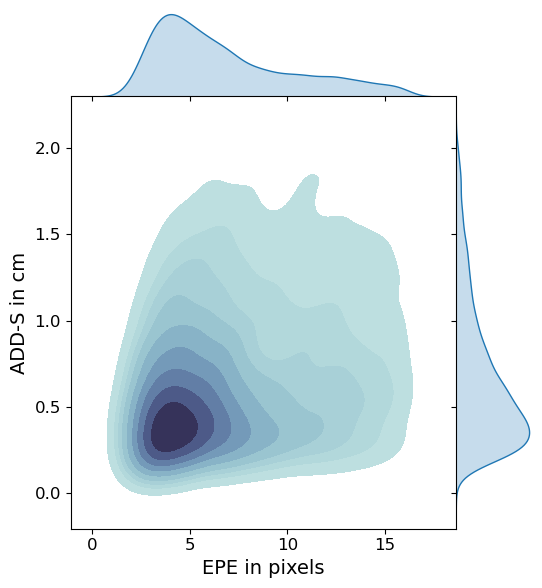

In [398]:
print("Experiment: ADD-S to EPE")

adds = df["adds"].to_numpy()
epe = df["epe"].to_numpy()

obj = df['idx_arr']
sym = []
for ind in obj.tolist():
  sym.append(
    not (int(ind) + 1 in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18])
  )
sym = np.array(sym)
epe = epe[sym == False]
adds = adds[sym == False]

m_fin = np.isfinite(epe)
epe = epe[m_fin]
adds = adds[m_fin]


m = (adds < np.quantile(adds[adds<0.1], 0.9) ) * (epe < np.quantile(epe, 0.8) )
epe = epe[m]
adds = adds[m]

for i in range(0,12):
    ma = ( epe < (i+1) )*( epe > i)
# KDE 2D density plot
df_plot = pd.DataFrame.from_dict( {'EPE in pixels':epe ,'ADD-S in cm':adds*100} ) 

ax = sns.jointplot(data = df_plot, x='EPE in pixels', y='ADD-S in cm',kind='kde', space=0, fill=True, thresh=0.05, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) )#')#  kind = 'hex',height =4.5) #color=sns.color_palette("bright")[-1]) # color = 'royalblue',  kind='kde'
# ax.fig.suptitle('ADD-(S) vs EPE', fontsize=12) #, verticalalignment='bottom');

ax.set_axis_labels("EPE in pixels","ADD-S in cm",fontsize=14)

plt.gcf().subplots_adjust(left=+0.2)

# ax.fig.yaxis.label.set_size(14)
ax.fig.savefig("/home/jonfrey/RPOSE/docs/adds_vs_epe.png", dpi = 600)

In [399]:
m.sum() / (sym == False).sum()

0.7560058134564418

In [ ]:
import seaborn as sns
add_s = df["add_s"].to_numpy()
ratio = df["ratios_arr"].to_numpy()

m = (add_s < np.quantile(add_s[add_s<0.1], 0.9) ) * (ratio > np.quantile(ratio, 0.3) )
ratio = ratio[m]
add_s = add_s[m]
# KDE 2D density plot
df_plot = pd.DataFrame.from_dict( {'Ratio':ratio ,'ADD-(S) in meters':add_s} ) 

ax = sns.jointplot(data = df_plot, x='Ratio', y='ADD-(S) in meters', kind = 'hex',height =4) # color = 'royalblue',  kind='kde'


In [ ]:
import seaborn as sns
add_s = df["add_s"].to_numpy()
repro_errors = df["repro_errors"].to_numpy()

m = (add_s < np.quantile(add_s[add_s<0.1], 0.9) ) * (repro_errors < np.quantile(repro_errors, 0.8) )
repro_error = repro_errors[m]
add_s = add_s[m]
# KDE 2D density plot
df_plot = pd.DataFrame.from_dict( {'Repro Error':repro_error ,'ADD-(S) in meters':add_s} ) 
ax = sns.jointplot(data = df_plot, x='Repro Error', y='ADD-(S) in meters', kind = 'hex',height =4) # color = 'royalblue',  kind='kde'

In [ ]:
import seaborn as sns
adds = df["adds"].to_numpy()
init_adds = df["init_adds_arr"].to_numpy()
import matplotlib.pyplot as plt 

m = (adds < np.quantile(adds[adds<0.1], 0.9) ) * (init_adds < np.quantile(init_adds[init_adds<0.1], 0.9) ) 
adds = adds[m]
init_adds= init_adds[m]

print(m.sum())
# KDE 2D density plot
df_plot = pd.DataFrame.from_dict( {'Init': init_adds ,'ADD-(S) in meters': adds} ) 
ax = sns.jointplot(data = df_plot, x='Init', y='ADD-(S) in meters', kind = 'hex',height =4) 

In [383]:
from pose_estimation import compute_auc
sym = [20,19,18,15,12]

def auc( k,obj,df):
    return round( compute_auc( df[k][df['idx_arr']==obj].to_numpy() ),2)
def bold(a,b):
    if a > b:
        return f'\033[1m {a} \033[0m vs {b}'#  + str(a) +'\033[0m' + ' vs ' + str(b)
    return f' {a} vs \033[1m {b} \033[0m'


for obj in range(0,21):
    s = ""
    if obj in sym:
        s+= '\033[1m'
    s+= f'ADDS-AUC {obj}: '
    if obj in sym:
        s+= '\033[0m'

    a,b =  auc('adds',obj,df), auc('adds',obj,df_posecnn)
    s+= bold(a,b)
    if 'init_adds_arr' in df.keys():
        s+= f"   init: {auc('init_adds_arr',obj,df)}"
    print(s)
    #print(auc('adds',obj,df),)

print( round( compute_auc( df['adds'].to_numpy() ),2) )
 
print("")
print("")
print("")


for obj in range(0,21):
    s = ""
    if obj in sym:
        s+= '\033[1m'
    s+= f'ADD-(S) AUC {obj}: '
    if obj in sym:
        s+= '\033[0m'
    
    a,b =  auc('add_s',obj,df), auc('add_s',obj,df_posecnn)
    s+= bold(a,b)
    if 'init_add_s_arr' in df.keys():
        s+= f"   init: {auc('init_add_s_arr',obj,df)}"
    print(auc('init_add_s_arr',obj,df))
print( round( compute_auc( df['add_s'].to_numpy() ),2) )

ADDS-AUC 0:  91.94  vs 87.84   init: 90.75
ADDS-AUC 1:  91.65  vs 80.48   init: 89.86
ADDS-AUC 2:  95.04  vs 74.1   init: 93.85
ADDS-AUC 3:  91.96  vs 83.94   init: 90.82
ADDS-AUC 4:  94.47  vs 90.09   init: 92.9
ADDS-AUC 5:  93.23  vs 87.52   init: 92.49
ADDS-AUC 6:  88.81  vs 70.02   init: 84.19
ADDS-AUC 7:  94.97  vs 88.59   init: 93.84
ADDS-AUC 8:  88.39  vs 85.97   init: 88.34
ADDS-AUC 9:  51.5 vs  87.0    init: 55.86
ADDS-AUC 10:  93.57  vs 86.21   init: 92.04
ADDS-AUC 11:  79.75  vs 65.36   init: 78.24
ADDS-AUC 12:  72.87 vs  73.06    init: 72.08
ADDS-AUC 13:  88.9  vs 76.28   init: 87.88
ADDS-AUC 14:  91.31  vs 74.83   init: 89.77
ADDS-AUC 15:  81.45  vs 25.29   init: 79.07
ADDS-AUC 16:  88.1  vs 62.96   init: 86.23
ADDS-AUC 17:  39.5 vs  71.95    init: 40.52
ADDS-AUC 18:  75.06  vs 41.26   init: 72.35
ADDS-AUC 19:  60.86  vs 30.48   init: 59.45
ADDS-AUC 20:  83.92 vs  85.09    init: 83.59
84.26



63.15
82.45
89.0
83.52
86.14
82.84
74.08
89.07
73.75
38.32
84.99
69.1
8.67
74.96

In [ ]:
print("EPE")
for obj in range(0,21):
    epe_obj = df['epe'][df['idx_arr']==obj].to_numpy()
    
    m = (epe_obj!= np.inf) * (np.isnan(epe_obj) != True)
    #print( obj, round( np.mean( epe_obj[m] ),2), "valids" , m.sum(), "total", epe_obj.shape[0])
    print( round( np.mean( epe_obj[m] ),2))

In [ ]:
from pose_estimation import compute_auc
sym = [20,19,18,15,12]

def auc( k,obj,df):
    return round( compute_auc( df[k][df['idx_arr']==obj].to_numpy() ),2)
def bold(a,b):
    if a > b:
        return f'\033[1m {a} \033[0m vs {b}'#  + str(a) +'\033[0m' + ' vs ' + str(b)
    return f' {a} vs \033[1m {b} \033[0m'

print("POSECNN RESULTS only RGB")
for obj in range(0,21):
    s = ""
    if obj in sym:
        s+= '\033[1m'
    s+= f'ADDS-AUC {obj}: '
    if obj in sym:
        s+= '\033[0m'
    s+= str(auc('adds',obj,df_posecnn))
    print(s)
    
print("all ", round( compute_auc( df_posecnn['adds'].to_numpy() ),2))

print("")
print("")
print("")


for obj in range(0,21):
    s = ""
    if obj in sym:
        s+= '\033[1m'
    s+= f'ADD-S AUC {obj}: '
    if obj in sym:
        s+= '\033[0m'
    
    s += str(auc('add_s',obj,df_posecnn))
    print(s)
    
print("all ", round( compute_auc( df_posecnn['add_s'].to_numpy() ),2))

In [238]:
from src_utils import load_yaml
import datasets

env = load_yaml(os.path.join('cfg/env', os.environ['ENV_WORKSTATION_NAME']+ '.yml'))
exp = load_yaml("cfg/exp/final/0_training_flow_reload/standard/standard.yml")
test_dataloader = datasets.fetch_dataloader( exp['test_dataset'], env )

test_dataloader.dataset.deterministic_random_shuffel()

{'pin_memory': True, 'batch_size': 1, 'shuffle': False, 'num_workers': 0}
Training with 14025 image pairs
Shuffeld the dataset


In [207]:
import pickle
with open('/home/jonfrey/PoseCNN-PyTorch/data_posecnn.pickle', 'rb') as handle:
    posecnn = pickle.load(handle)
data_posecnn = {}
data_posecnn['add_s'] = np.array( [d['distances_non'] for d in posecnn])
data_posecnn['adds'] = np.array( [d['distances_sys'] for d in posecnn])
data_posecnn['idx_arr'] = np.array( [d['cls_index']-1 for d in posecnn])
df_posecnn = pd.DataFrame.from_dict( data_posecnn ) 
df_posecnn 

,add_s,adds,idx_arr
0,0.010331,0.006101,0
1,0.015830,0.005267,5
2,0.082734,0.047821,13
3,0.127282,0.081377,18
4,0.058098,0.032544,19
...,...,...,...
14020,0.014305,0.007267,3
14021,0.021800,0.012786,5
14022,0.010457,0.004589,8
14023,0.050037,0.017271,14


In [208]:
import torch

from ycb.rotations import *
def deg( a,b ): 
    a = torch.tensor( a ) [:3,:3][None]
    b = torch.tensor( b ) [:3,:3][None]
    return np.rad2deg( float(so3_relative_angle(a,b) ))

def trans(a,b):
    return float( np.linalg.norm( (a-b)[:3,3] ) )

from loss import AddSLoss
adds = AddSLoss( sym_list = list( range(0,22)))
add = AddSLoss( sym_list = []) # bowl, wood_block, large clamp, extra_large clamp, foam_brick

In [248]:
# POSECNN CREATION
mode = "posecnn"

# Use predicted poses
# mode = "pred"

import copy
import random
import scipy.io as scio

ds = test_dataloader.dataset
pose_cnn_data = ds._posecnn_data
ds.estimate_pose = True
ds.err = True
ds.valid_flow_minimum = 0
ds.fake_flow = True

translations = np.zeros( len(ds) ); translations[:] = np.inf
rotations = np.zeros( len(ds) ); rotations[:] = np.inf
results_adds = np.zeros( len(ds) ); results_adds[:] = np.inf
results_add = np.zeros( len(ds) ); results_add[:] = np.inf

import time
st = time.time()


for i in range( len(ds) ):
    if i % 50 == 0:
        print(i, time.time()-st) 
    obj_idx = ds._obj_idx_list[i]
    
    if obj_idx-1 in [12,15,18,19,20]:
        continue
        
    p = ds._base_path_list[i]
    
    dellist = [j for j in range(0, len(ds._pcd_cad_list[obj_idx-1]))]
    dellist = random.sample(dellist, len(
      ds._pcd_cad_list[obj_idx-1]) - ds._num_pt_cad_model)
    model_points = np.delete(ds._pcd_cad_list[obj_idx-1], dellist, axis=0).astype(np.float32)
    
    meta = scio.loadmat( p+"-meta.mat")
    
    obj = meta['cls_indexes'].flatten().astype(np.int32)
    obj_idx_in_list = int( np.argwhere(obj == obj_idx) )
    h_gt = np.eye(4)
    h_gt[:3,:4] =  meta['poses'][:, :, obj_idx_in_list]   
    h_gt = h_gt.astype(np.float32)
    
    
    if mode == "pred":
        h_pred = (data["h_pred_all"][i,0]).astype(np.float32)
    elif mode == "posecnn":
        h_pred = ds._get_init_pose_posecnn( obj_idx, p).astype(np.float32)
        
    
    translations[i] = trans(h_gt,h_pred)
    rotations[i] = deg(h_gt,h_pred)
    
    target = model_points @ h_gt[:3,:3].T \
        + h_gt[:3,3][:,None].repeat(model_points.shape[0], 1).T
    
    _adds = adds( torch.from_numpy(target)[None].cuda(), 
          torch.from_numpy(model_points)[None].cuda(), 
          torch.tensor([[obj_idx]]).cuda(), 
          H=torch.from_numpy(h_pred)[None].cuda())
    _add = add( torch.from_numpy(target)[None].cuda(), 
      torch.from_numpy(model_points)[None].cuda(), 
      torch.tensor([[obj_idx]]).cuda(), 
      H=torch.from_numpy(h_pred)[None].cuda())
    
    results_adds[i] = _adds.cpu().numpy()
    results_add[i] = _add.cpu().numpy()

if mode == "pred":
    pred_translations = copy.deepcopy(translations)
    pred_rotations = copy.deepcopy(rotations)
    
elif mode == "posecnn":
    posecnn_translations = copy.deepcopy(translations)
    posecnn_rotations = copy.deepcopy(rotations)
    

0 0.00028443336486816406
50 0.9454905986785889
100 1.879955768585205
150 2.7496156692504883
200 3.725820541381836
250 4.617452144622803
300 5.510898113250732
350 6.29220175743103
400 7.230551481246948
450 8.074732065200806
500 8.929011583328247
550 9.817927122116089
600 10.716233491897583
650 11.669451713562012
700 12.472770690917969
750 13.261141300201416
800 14.095157861709595
850 15.050531387329102
900 15.963546752929688
950 16.858174085617065
1000 17.809489727020264
1050 18.662165880203247
1100 19.60003685951233
1150 20.454653024673462
1200 21.290764093399048
1250 22.122448444366455
1300 23.041297435760498
1350 23.89569902420044
1400 24.695793628692627
1450 25.614110708236694
1500 26.44384479522705
1550 27.33796262741089
1600 28.05860662460327
1650 28.973479747772217
1700 29.800790786743164
1750 30.760358810424805
1800 31.650970220565796
1850 32.591267108917236
1900 33.49961256980896
1950 34.417109966278076
2000 35.34657287597656
2050 36.262386322021484
2100 37.182029485702515
2150

In [242]:
import copy
pred_translations = copy.deepcopy(translations)
pred_rotations = copy.deepcopy(rotations)

In [246]:
sns.color_palette("hls", 8)[2]

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

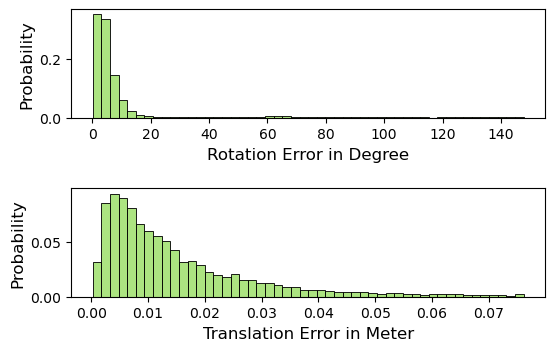

In [247]:
results_adds
import seaborn as sns
from matplotlib import pyplot
sns.reset_defaults() 

rotations = pred_rotations
translation = pred_translation

fig, axs = pyplot.subplots(2, figsize=(6,4))
fig.tight_layout(pad=3.0)
r = rotations[rotations<np.inf]
t = translations[translations<np.inf]

m = (r<np.quantile(r, 0.95)) * (t<np.quantile(t, 0.95))
df_plot = pd.DataFrame.from_dict( {'Rotation Error': r[m] ,
                                   'Translation Error': t[m]  } ) 

with sns.plotting_context(font_scale=5):
    sns.histplot(ax=axs[0], data = df_plot['Rotation Error'],bins=50 , stat="probability",color = sns.color_palette("hls", 8)[2] ) 
    axs[0].set_xlabel('Rotation Error in Degree',fontsize=12)
    axs[0].set_ylabel('Probability',fontsize=12)
    sns.histplot(ax=axs[1], data = df_plot['Translation Error'] ,bins=50 , stat="probability",color = sns.color_palette("hls", 8)[2] )
    axs[1].set_xlabel('Translation Error in Meter',fontsize=12)
    axs[1].set_ylabel('Probability',fontsize=12)

#
 # color = 'royalblue',  kind='kde'
# ax.fig.suptitle('ADD-(S) vs EPE', fontsize=12) #, verticalalignment='bottom');
fig.savefig("/home/jonfrey/RPOSE/docs/init_posecnn.png", dpi = 600)


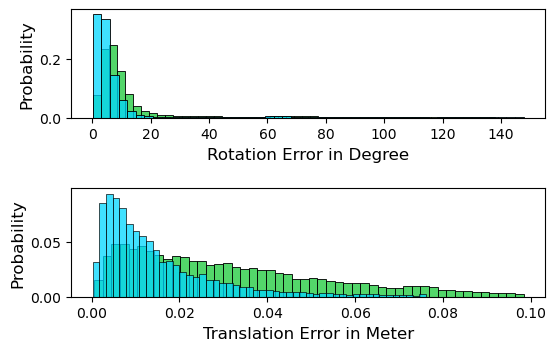

In [266]:
results_adds
import seaborn as sns
from matplotlib import pyplot
sns.reset_defaults() 
fig, axs = pyplot.subplots(2, figsize=(6,4))
fig.tight_layout(pad=3.0)
with sns.plotting_context(font_scale=5):

    rots = [ posecnn_rotations, pred_rotations ]
    trans = [posecnn_translations ,  pred_translations]
    cols = [sns.color_palette("bright")[2] ,sns.color_palette("bright")[-1]] #[sns.color_palette("Paired")[0],sns.color_palette("Paired")[2]]
    for rotations, translations,col in zip(rots, trans, cols):
        
        r = rotations[rotations<np.inf]
        t = translations[translations<np.inf]

        m = (r<np.quantile(r, 0.95)) * (t<np.quantile(t, 0.95))
        df_plot = pd.DataFrame.from_dict( {'Rotation Error': r[m] ,
                                           'Translation Error': t[m]  } ) 
        
        sns.histplot(ax=axs[0], data = df_plot['Rotation Error'],bins=50 , stat="probability",color = col ) 
        axs[0].set_xlabel('Rotation Error in Degree',fontsize=12)
        axs[0].set_ylabel('Probability',fontsize=12)
        sns.histplot(ax=axs[1], data = df_plot['Translation Error'] ,bins=50 , stat="probability",color = col )
        axs[1].set_xlabel('Translation Error in Meter',fontsize=12)
        axs[1].set_ylabel('Probability',fontsize=12)

        #
         # color = 'royalblue',  kind='kde'
        # ax.fig.suptitle('ADD-(S) vs EPE', fontsize=12) #, verticalalignment='bottom');
    fig.savefig("/home/jonfrey/RPOSE/docs/init_posecnn_vs_output.png", dpi = 600)


In [304]:
obj = data["idx_arr"]
sym = []
for ind in obj.tolist():
  sym.append(
    not (int(ind) + 1 in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18])
  )
sym = np.array(sym)
    

rotations, translations = posecnn_rotations[sym == False], posecnn_translations[sym == False]
r = rotations[rotations<np.inf]
t = translations[translations<np.inf]
m = (r<np.quantile(r, 0.95)) * (t<np.quantile(t, 0.99))

print( np.mean( r[m] ),np.mean( t[m] ) )

rotations, translations = pred_rotations[sym == False], pred_translations[sym == False]
r = rotations[rotations<np.inf]
t = translations[translations<np.inf]
m = (r<np.quantile(r, 0.95)) * (t<np.quantile(t, 0.99))

np.mean( r[m] ),np.mean( t[m] )

# np.mean( posecnn_translations[posecnn_translations<np.inf] ),  np.mean( pred_translations [pred_translations <np.inf]) 

15.012721643353606 0.03500106481595364


(11.758567711456791, 0.018691591703639304)

0.07612779811024664